In [2]:
!pip install tensorflow
!pip install datasets transformers[sentencepiece] sacrebleu -q

In [ ]:
import tensorflow as tf
import os 
import sys
import transformers
import tensorflow as tf
from datasets import load_dataset, DatasetDict, load_metric
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, AdamWeightDecay, AutoTokenizer, TFAutoModelForSeq2SeqLM
from transformers import AdamW
from tqdm import tqdm  


import nltk
from nltk.translate.bleu_score import sentence_bleu
from bert_score import score
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
import pandas as pd






In [4]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "AVAILABLE_CUDA_DEVICE_NAME" 
# Get the list of available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

In [6]:
model_checkpoint = "google-t5/t5-small"

In [24]:
test_data

Dataset({
    features: ['translation'],
    num_rows: 2999
})

In [ ]:

metric = load_metric("sacrebleu")

# Load the training dataset
train_data = load_dataset("wmt16", "de-en", split="train[:50000]")

# Load the validation dataset
val_data = load_dataset("wmt16", "de-en", split="validation")

# Load the test dataset
test_data = load_dataset("wmt16", "de-en", split="test")

# Create a DatasetDict
raw_datasets = DatasetDict({
    'train': train_data,
    'validation': val_data,
    'test': test_data
})

print(raw_datasets)


In [30]:
raw_datasets['train'][45]

{'translation': {'de': 'Warum wurde nach meinem Unfall nichts unternommen, um die Treppen sicherer zu machen?',
  'en': 'Why have the staircases not been improved since my accident?'}}

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

prefix = "translation german to english"
source_lang = "de"
target_lang = "en"

def preprocess_function(dataset):
    inputs = [prefix + ex[source_lang] for ex in dataset["translation"]]
    targets = [ex[target_lang] for ex in dataset["translation"]]
    
    # Tokenize inputs without truncation
    model_inputs = tokenizer(inputs, truncation=True)
    
    # Tokenize targets without truncation
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, truncation=True)
    
    # Modify model_inputs to include labels
    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs


In [ ]:
preprocess_function(raw_datasets['train'][:2])
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
data_collator = DataCollatorForSeq2Seq(tokenizer,model=model)

In [ ]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True
)

optimizer = AdamW(model.parameters(), lr=args.learning_rate)

# Lists to store losses
training_losses = []
validation_losses = []

def compute_loss(model, inputs):
    outputs = model(**inputs)
    # Customize this based on your model's output
    loss = outputs.loss
    return loss

trainer = Seq2SeqTrainer(
    
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=None, 
    optimizers=(optimizer, None) 

# Training loop
for epoch in range(args.num_train_epochs):
    # Train
    train_loss = 0
    progress_bar = tqdm(trainer.get_train_dataloader(), desc=f'Epoch {epoch + 1}', leave=False)
    for step, batch in enumerate(progress_bar):
        inputs = {k: v.to(trainer.args.device) for k, v in batch.items()}
        model.train()
        loss = compute_loss(model, inputs)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        progress_bar.set_postfix({'training_loss': train_loss / (step + 1)})  
    
    # Calculate average training loss for the epoch
    train_loss /= len(tokenized_datasets["train"])
    training_losses.append(train_loss)
    
    # Validation
    val_loss = trainer.evaluate()
    validation_losses.append(val_loss['eval_loss'])

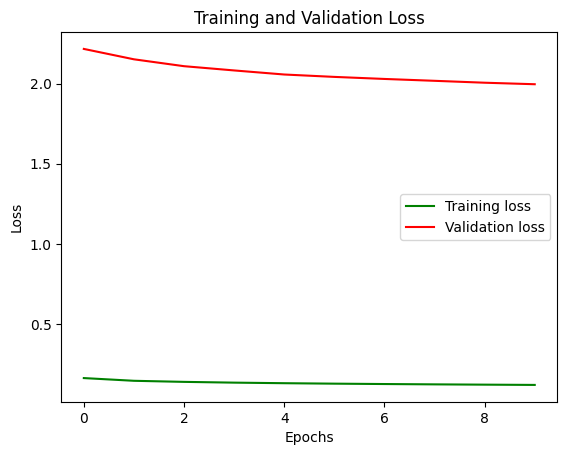

In [22]:
import matplotlib.pyplot as plt


plt.plot( training_losses, 'g', label='Training loss')
plt.plot( validation_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("/t5_fine_tunning_model")
model = TFAutoModelForSeq2SeqLM.from_pretrained("/t5_fine_tunning_model")

validation data

In [ ]:
val_references = [example['translation']['en'] for example in val_data]
val_germen= [example['translation']['de'] for example in val_data]

In [ ]:
# Define a translation function
def translate_batch(model, tokenizer, german_sentences):
    inputs = tokenizer(german_sentences, return_tensors="pt", padding=True, truncation=True)
    outputs = model.generate(**inputs)
    translated_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return translated_texts

# Translate all German sentences to English
english_translations = translate_batch(model, tokenizer, val_germen)



In [ ]:

# Initialize variables to store cumulative BLEU scores for each n-gram precision
total_bleu1 = 0
total_bleu2 = 0
total_bleu3 = 0
total_bleu4 = 0

# Calculate BLEU score for each predicted sentence
for i, pred in enumerate(english_translations):
    reference = val_references[i % len(val_references)]  # Use the same reference for each predicted sentence
    
    # Tokenize reference and predicted sentences
    reference_tokens = reference.split()
    predicted_tokens = pred.split()
    
    # Calculate BLEU scores for n-grams up to 4
    bleu1 = sentence_bleu([reference_tokens], predicted_tokens, weights=(1, 0, 0, 0))
    bleu2 = sentence_bleu([reference_tokens], predicted_tokens, weights=(0.5, 0.5, 0, 0))
    bleu3 = sentence_bleu([reference_tokens], predicted_tokens, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = sentence_bleu([reference_tokens], predicted_tokens, weights=(0.25, 0.25, 0.25, 0.25))
    
    # Accumulate BLEU scores
    total_bleu1 += bleu1
    total_bleu2 += bleu2
    total_bleu3 += bleu3
    total_bleu4 += bleu4

# Calculate average BLEU scores for each n-gram precision
avg_bleu1 = total_bleu1 / len(english_translations)
avg_bleu2 = total_bleu2 / len(english_translations)
avg_bleu3 = total_bleu3 / len(english_translations)
avg_bleu4 = total_bleu4 / len(english_translations)

print(f"Average BLEU-1: {avg_bleu1}")
print(f"Average BLEU-2: {avg_bleu2}")
print(f"Average BLEU-3: {avg_bleu3}")
print(f"Average BLEU-4: {avg_bleu4}")



In [ ]:
from bert_score import score
# Calculate BERT score
P, R, F1 = score(english_translations, val_references, lang='en', verbose=True)

print("Precision:", P.mean())
print("Recall:", R.mean())
print("F1 Score:", F1.mean())


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 68/68 [00:08<00:00,  7.67it/s]


computing greedy matching.


100%|██████████| 34/34 [00:00<00:00, 65.52it/s]


done in 9.40 seconds, 230.78 sentences/sec
Precision: tensor(0.8954)
Recall: tensor(0.8856)
F1 Score: tensor(0.8903)


In [ ]:

from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
# Join the list of references into a single string with tokens separated by spaces
references_string = " ".join(val_references)
predicted_string = " ".join(english_translations)

# Tokenize the strings into lists of words
reference_tokens = word_tokenize(references_string)
predicted_tokens = word_tokenize(predicted_string)

# Calculate METEOR score
score = meteor_score([reference_tokens], predicted_tokens)
print("METEOR score:", score)



METEOR score: 0.3042717075383296


## Test Data

In [ ]:
test_references = [example['translation']['en'] for example in test_data]
teset_german= [example['translation']['de'] for example in test_data]

In [ ]:
# Define a translation function
def translate_batch(model, tokenizer, german_sentences):
    inputs = tokenizer(german_sentences, return_tensors="pt", padding=True, truncation=True)
    outputs = model.generate(**inputs)
    translated_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return translated_texts

# Translate all German sentences to English
english_test_translations = translate_batch(model, tokenizer, tset_germen)



In [ ]:
# Initialize variables to store cumulative BLEU scores for each n-gram precision
total_bleu1 = 0
total_bleu2 = 0
total_bleu3 = 0
total_bleu4 = 0

# Calculate BLEU score for each predicted sentence
for i, pred in enumerate(english_test_translations):
    reference = val_references[i % len(test_references)]  # Use the same reference for each predicted sentence
    
    # Tokenize reference and predicted sentences
    reference_tokens = reference.split()
    predicted_tokens = pred.split()
    
    # Calculate BLEU scores for n-grams up to 4
    bleu1 = sentence_bleu([reference_tokens], predicted_tokens, weights=(1, 0, 0, 0))
    bleu2 = sentence_bleu([reference_tokens], predicted_tokens, weights=(0.5, 0.5, 0, 0))
    bleu3 = sentence_bleu([reference_tokens], predicted_tokens, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = sentence_bleu([reference_tokens], predicted_tokens, weights=(0.25, 0.25, 0.25, 0.25))
    
    # Accumulate BLEU scores
    total_bleu1 += bleu1
    total_bleu2 += bleu2
    total_bleu3 += bleu3
    total_bleu4 += bleu4

# Calculate average BLEU scores for each n-gram precision
avg_bleu1 = total_bleu1 / len(english_test_translations)
avg_bleu2 = total_bleu2 / len(english_test_translations)
avg_bleu3 = total_bleu3 / len(english_test_translations)
avg_bleu4 = total_bleu4 / len(english_test_translations)

print(f"Average BLEU-1: {avg_bleu1}")
print(f"Average BLEU-2: {avg_bleu2}")
print(f"Average BLEU-3: {avg_bleu3}")
print(f"Average BLEU-4: {avg_bleu4}")



In [ ]:
# Calculate BERT score
P, R, F1 = score(english_test_translations, test_references, lang='en', verbose=True)

print("Precision:", P.mean())
print("Recall:", R.mean())
print("F1 Score:", F1.mean())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 94/94 [00:12<00:00,  7.81it/s]


computing greedy matching.


100%|██████████| 47/47 [00:00<00:00, 65.52it/s]


done in 12.79 seconds, 234.50 sentences/sec
Precision: tensor(0.8997)
Recall: tensor(0.8896)
F1 Score: tensor(0.8944)


In [ ]:
# Join the list of references into a single string with tokens separated by spaces
references_string = " ".join(test_references)
predicted_string = " ".join(english_test_translations)

# Tokenize the strings into lists of words
reference_tokens = word_tokenize(references_string)
predicted_tokens = word_tokenize(predicted_string)

# Calculate METEOR score
score = meteor_score([reference_tokens], predicted_tokens)
print("METEOR score:", score)

METEOR score: 0.31437722593472905


Inference Pipeline

In [ ]:


# Read CSV file
df = pd.read_csv("/test.csv")

# Assuming your German text column is named 'German'
german_texts = df['de'].tolist()

# Tokenize German input texts
german_inputs = tokenizer(german_texts, return_tensors="tf", padding=True, truncation=True)

# Generate translations for German input texts
translated = model.generate(input_ids=german_inputs['input_ids'], attention_mask=german_inputs['attention_mask'])

# Decode generated translations
decoded_translations = [tokenizer.decode(t, skip_special_tokens=True) for t in translated]

# Create a DataFrame with German sentences and their corresponding English translations
translation_df = pd.DataFrame({'de': german_texts, 'en': decoded_translations})

# Save the DataFrame to a CSV file
translation_df.to_csv("/output.csv", index=False)


In [9]:
pd.read_csv('/output.csv')

,de,en
0,Im Parlament besteht der Wunsch nach einer Aus...,Parliament wants to have a debate in the cours...
1,Wiederaufnahme der Sitzungsperiode,Reaufnahme of the session
2,Warum wurde nach meinem Unfall nichts unternom...,Why has nothing been done after my accident to...
